In [1]:
%matplotlib inline
from pathlib import Path
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import matplotlib.pylab as plt
from dmba import plotDecisionTree, classificationSummary, regressionSummary
from graphviz import Digraph
import pydotplus
import graphviz
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from surprise import Dataset, Reader, KNNBasic
from surprise.model_selection import train_test_split
from mlxtend.preprocessing import TransactionEncoder
from sklearn.preprocessing import OneHotEncoder

no display found. Using non-interactive Agg backend


# Clustering Entire Data Set

In [2]:
# create df and drop irrelevant columns of entire dataset
df = pd.read_excel("Project1_Data.xlsx")
df.set_index('userid', inplace=True)
df.drop(['site1', 'site2', 'site3', 'site4', 'site5'], axis=1, inplace=True)
#df = df.apply(lambda x: x.astype('float64'))
df

,education,region,hhsz,age,income,child,race,connection,country,zipcode,money
userid,,,,,,,,,,,
14840503,99,4,5,6,2,1,1,1,0,94954,657.93
12890751,4,2,2,8,4,1,1,1,0,46038,178.80
13129562,4,2,4,8,5,1,1,1,0,64504,483.44
12910664,99,3,4,4,2,1,1,1,0,31554,148.85
13601071,99,3,3,7,4,0,1,1,0,40033,801.40
...,...,...,...,...,...,...,...,...,...,...,...
14606550,99,3,2,3,3,0,1,1,0,37923,84.89
14590791,99,2,3,7,7,1,1,1,0,43351,200.88
14917811,1,4,2,3,2,0,1,0,0,99338,161.88


In [3]:
# find clusters for noramlized data of entire dataset
df_norm = df.apply(preprocessing.scale, axis = 0)
kmeans = KMeans(n_clusters = 5, random_state = 0).fit(df_norm)
preds = kmeans.predict(df_norm)
memb = pd.Series(kmeans.labels_, index = df_norm.index)

In [4]:
# find centers for normalized data of entire dataset
centroids = pd.DataFrame(kmeans.cluster_centers_, columns = df.columns)
pd.set_option('display.precision', 3)
print(centroids)

   education  region   hhsz    age  income  child   race  connection  \
0     -0.347   0.003 -0.200 -0.078  -0.391 -0.167  5.381       0.022   
1     -0.015   0.564  0.316 -0.038   0.075  0.594 -0.149       0.282   
2      0.013  -1.197  0.387  0.111   0.236  0.558 -0.149       0.282   
3      0.080  -0.015 -0.943 -0.067  -0.233 -1.664 -0.149       0.282   
4     -0.062   0.108 -0.135  0.144  -0.315 -0.164 -0.149      -3.546   

     country  zipcode  money  
0  5.575e-02    0.017  0.198  
1 -5.206e-04    0.499 -0.025  
2 -6.057e-02   -1.073  0.163  
3 -6.604e-02    0.014 -0.077  
4  3.750e-01    0.048 -0.171  


In [6]:
# graph normalized data of entire dataset
pd.set_option('display.precision', 6)
centroids['cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
fig=plt.figure(figsize=(5,5),facecolor='white')
fig.subplots_adjust(right=3)
ax = parallel_coordinates(centroids, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)

(-0.5, 7.5)

# Cluster users who went to victoriassecret.com and also oldnavy.com

In [8]:
# create new df that will be used for association rules that will eventually be used for
# users who went to victoriassecret.com who also went to oldnavy.com
df_1 = pd.read_excel("Project1_Data.xlsx")
df_1.set_index('userid', inplace=True)
df_1.drop(['education', 'region', 'hhsz', 'age', 'income', 'child', 'race', 'connection', 'country', 'zipcode', 'money'], axis=1, inplace=True)

In [9]:
# create one hot encoding for entire dataset
df_1['user_sites'] = df_1.apply(lambda x: ', '.join(x.dropna()), axis=1)
df_1_one_hot = df_1['user_sites'].str.get_dummies(', ')

In [20]:
# filter the one hot encoding to only show users who went to victoriassecret.com who also went to oldnavy.com
df_2 = df_1_one_hot[df_1_one_hot['victoriassecret.com'] == 1]
df_3 = df_1_one_hot[df_1_one_hot['oldnavy.com'] == 1]
cols_to_use = df_3.columns.difference(df_2.columns)
df_4 = pd.merge(df_2, df_3[cols_to_use], left_index=True, right_index=True)
print('Number of users who went to victoriassecret.com who also went to oldnavy.com: ', len(df_4))

Number of users who went to victoriassecret.com who also went to oldnavy.com:  299


In [11]:
# create another df that will be used for clustering users who went to 
# victoriassecret.com who also went to oldnavy.com
df_01 = pd.read_excel("Project1_Data.xlsx")
df_01.set_index('userid', inplace=True)
df_01.drop(['site1', 'site2', 'site3', 'site4', 'site5'], axis=1, inplace=True)

In [12]:
# create a new dataframe based on users that went to victoriassecret.com and oldnavy.com
# shows attributes only so we can cluster them
cols_to_use_01 = df_01.columns.difference(df_4.columns)
df_4 = pd.merge(df_01, df_4[cols_to_use], left_index=True, right_index=True)

In [13]:
# find clusters for normalized data of those who went to victoriassecret.com and oldnavy.com
df_norm_4 = df_4.apply(preprocessing.scale, axis = 0)
kmeans_1 = KMeans(n_clusters = 5, random_state = 0).fit(df_norm_4)
preds_01 = kmeans.predict(df_norm_4)
memb_01 = pd.Series(kmeans_1.labels_, index = df_norm_4.index)

In [14]:
# find centers for normalized data of those who went to victoriassecret.com and oldnavy.com
centroids_1 = pd.DataFrame(kmeans_1.cluster_centers_, columns = df_4.columns)
pd.set_option('display.precision', 3)
print(centroids_1)

   education  region   hhsz    age  income  child   race  connection  country  \
0      0.312   0.628  0.440 -0.162   0.112  0.646 -0.203       0.246   -0.155   
1      0.050   0.037 -0.837 -0.001  -0.120 -1.500 -0.203       0.246   -0.056   
2     -0.440  -0.875  0.258  0.216   0.125  0.667 -0.203       0.246    0.144   
3     -0.137   0.084  0.137  0.089  -0.344  0.284 -0.203      -4.073    0.148   
4      0.022  -0.084 -0.013 -0.117  -0.466 -0.167  4.468       0.246    0.542   

   zipcode  money  
0    0.601  0.009  
1    0.018  0.034  
2   -0.789  0.052  
3    0.061 -0.182  
4   -0.242 -0.376  


(-0.5, 7.5)

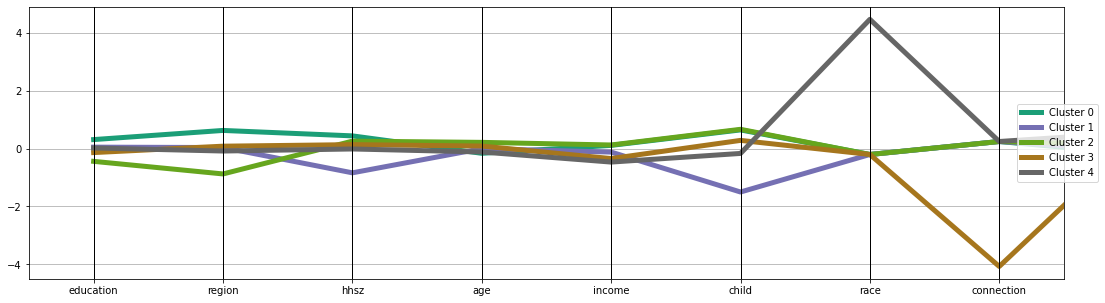

In [15]:
# Hello - graph normalized data for clusters of of those who went to victoriassecret.com and oldnavy.com
pd.set_option('display.precision', 6)
centroids_1['cluster'] = ['Cluster {}'.format(i) for i in centroids_1.index]
fig_1=plt.figure(figsize=(5,5),facecolor='white')
fig_1.subplots_adjust(right=3)
ax_1 = parallel_coordinates(centroids_1, class_column='cluster', colormap='Dark2', linewidth=5)
plt.legend(loc='center left', bbox_to_anchor=(0.95, 0.5))
plt.xlim(-0.5,7.5)

# Association Rules for Cluster 0 from users who went to victoriassecret.com who also went to oldnavy.com

In [16]:
# create a dataframe from the series memb for cluster 0 
# this is so we can filter the cluster column
df_clusters_1 = pd.DataFrame(memb_01)
df_clusters_1.columns = ['cluster']

In [17]:
# create df of those users in cluster 0 
df_who_is_in_cluster_0_1 = df_clusters_1[df_clusters_1['cluster'] == 0]
df_cluster0_1 = pd.merge(df_who_is_in_cluster_0_1, df_1_one_hot, left_index=True, right_index=True)
df_cluster0_1.drop(['cluster'], axis=1, inplace=True)
print('Number of users who went to victoriassecret.com and oldnavy.com in cluster 0: ', len(df_cluster0_1))

Number of users who went to victoriassecret.com and oldnavy.com in cluster 0:  106


In [18]:
# association rules for cluster 0
itemsets_1 = apriori(df_cluster0_1, min_support=0.2, use_colnames=True)
rules_1 = association_rules(itemsets_1, metric='confidence', min_threshold=0.5)
rules_1.sort_values(by=['support'], ascending=False)

C:\Users\justin\anaconda3\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
4,(victoriassecret.com),(oldnavy.com),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
5,(oldnavy.com),(victoriassecret.com),1.000000,1.0,1.000000,1.0,1.0,0.0,inf
0,(gap.com),(oldnavy.com),0.245283,1.0,0.245283,1.0,1.0,0.0,inf
1,(gap.com),(victoriassecret.com),0.245283,1.0,0.245283,1.0,1.0,0.0,inf
6,"(gap.com, victoriassecret.com)",(oldnavy.com),0.245283,1.0,0.245283,1.0,1.0,0.0,inf
7,"(gap.com, oldnavy.com)",(victoriassecret.com),0.245283,1.0,0.245283,1.0,1.0,0.0,inf
8,(gap.com),"(victoriassecret.com, oldnavy.com)",0.245283,1.0,0.245283,1.0,1.0,0.0,inf
2,(jcpenney.com),(oldnavy.com),0.207547,1.0,0.207547,1.0,1.0,0.0,inf
3,(jcpenney.com),(victoriassecret.com),0.207547,1.0,0.207547,1.0,1.0,0.0,inf
9,"(jcpenney.com, victoriassecret.com)",(oldnavy.com),0.207547,1.0,0.207547,1.0,1.0,0.0,inf
